In [1]:
# Import packages and libraries from a previous multiple linear regression model
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing

In [2]:
# Grabbing data from the csv files. 
spi = pd.read_csv("C:/Users/cklni/Desktop/WGU/D214/sp500_index.csv")
sps = pd.read_csv("C:/Users/cklni/Desktop/WGU/D214/sp500_stocks.csv")

In [3]:
spi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2535 entries, 0 to 2534
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2535 non-null   object 
 1   S&P500  2535 non-null   float64
dtypes: float64(1), object(1)
memory usage: 39.7+ KB


In [4]:
sps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1832429 entries, 0 to 1832428
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Date       object 
 1   Symbol     object 
 2   Adj Close  float64
 3   Close      float64
 4   High       float64
 5   Low        float64
 6   Open       float64
 7   Volume     float64
dtypes: float64(6), object(2)
memory usage: 111.8+ MB


In [5]:
# Pulling out just the rows that have are for the big tech companies
filter_values = ['AAPL', 'ADBE', 'AMZN', 'CRM', 'CSCO', 'GOOGL', 'IBM', 'INTC', 'META', 'MSFT', 'NFLX', 'NVDA', 'ORCL', 'TSLA']

# Filter rows where any column contains any of the values in filter_values
bts = sps[sps['Symbol'].isin(filter_values)]

In [6]:
bts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51002 entries, 18215 to 1617491
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       51002 non-null  object 
 1   Symbol     51002 non-null  object 
 2   Adj Close  50281 non-null  float64
 3   Close      50281 non-null  float64
 4   High       50281 non-null  float64
 5   Low        50281 non-null  float64
 6   Open       50281 non-null  float64
 7   Volume     50281 non-null  float64
dtypes: float64(6), object(2)
memory usage: 3.5+ MB


In [7]:
# Identify rows with any null values
rows_with_nulls = bts[bts.isnull().any(axis=1)]

# Display rows with null values
print("Rows with Null Values:")
print(rows_with_nulls)

Rows with Null Values:
               Date Symbol  Adj Close  Close  High  Low  Open  Volume
1143902  2010-01-04   META        NaN    NaN   NaN  NaN   NaN     NaN
1143903  2010-01-05   META        NaN    NaN   NaN  NaN   NaN     NaN
1143904  2010-01-06   META        NaN    NaN   NaN  NaN   NaN     NaN
1143905  2010-01-07   META        NaN    NaN   NaN  NaN   NaN     NaN
1143906  2010-01-08   META        NaN    NaN   NaN  NaN   NaN     NaN
...             ...    ...        ...    ...   ...  ...   ...     ...
1613966  2010-06-22   TSLA        NaN    NaN   NaN  NaN   NaN     NaN
1613967  2010-06-23   TSLA        NaN    NaN   NaN  NaN   NaN     NaN
1613968  2010-06-24   TSLA        NaN    NaN   NaN  NaN   NaN     NaN
1613969  2010-06-25   TSLA        NaN    NaN   NaN  NaN   NaN     NaN
1613970  2010-06-28   TSLA        NaN    NaN   NaN  NaN   NaN     NaN

[721 rows x 8 columns]


In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
# META did not go public until May 18th 2012 so I will be dropping rows that are from before that.
bts['Date'] = pd.to_datetime(bts['Date'])
cutoff_date = pd.Timestamp('2012-05-18')

bts1 = bts[bts['Date'] >= cutoff_date]

In [10]:
bts1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42616 entries, 18814 to 1617491
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       42616 non-null  datetime64[ns]
 1   Symbol     42616 non-null  object        
 2   Adj Close  42616 non-null  float64       
 3   Close      42616 non-null  float64       
 4   High       42616 non-null  float64       
 5   Low        42616 non-null  float64       
 6   Open       42616 non-null  float64       
 7   Volume     42616 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 2.9+ MB


In [11]:
bts1['Symbol'].nunique()

14

In [12]:
# Need to drop rows from the S&P 500 index data also
spi['Date'] = pd.to_datetime(spi['Date'])
cutoff_date = pd.Timestamp('2012-05-18')

spi1 = spi[spi['Date'] >= cutoff_date]

In [13]:
spi1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2535 entries, 0 to 2534
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2535 non-null   datetime64[ns]
 1   S&P500  2535 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 59.4 KB


In [14]:
# Noticed that no rows dropped, so I will look see the date that start the dataset
spi1['Date']

0      2014-05-30
1      2014-06-02
2      2014-06-03
3      2014-06-04
4      2014-06-05
          ...    
2530   2024-06-18
2531   2024-06-20
2532   2024-06-21
2533   2024-06-24
2534   2024-06-25
Name: Date, Length: 2535, dtype: datetime64[ns]

In [15]:
# Need to cut more dates to match S&P500 index dates
cutoff_date = pd.Timestamp('2014-05-30')

bts1 = bts1[bts1['Date'] >= cutoff_date]
bts1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35490 entries, 19323 to 1617491
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       35490 non-null  datetime64[ns]
 1   Symbol     35490 non-null  object        
 2   Adj Close  35490 non-null  float64       
 3   Close      35490 non-null  float64       
 4   High       35490 non-null  float64       
 5   Low        35490 non-null  float64       
 6   Open       35490 non-null  float64       
 7   Volume     35490 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 2.4+ MB


In [16]:
#Checking the earliest date matches
bts1['Date']

19323     2014-05-30
19324     2014-06-02
19325     2014-06-03
19326     2014-06-04
19327     2014-06-05
             ...    
1617487   2024-06-18
1617488   2024-06-20
1617489   2024-06-21
1617490   2024-06-24
1617491   2024-06-25
Name: Date, Length: 35490, dtype: datetime64[ns]

In [17]:
# Merging the two datasets on the 'Date' column
mdf = pd.merge(bts1, spi1, on='Date')

# Display the merged DataFrame
print("Merged DataFrame:")
print(mdf.head())

Merged DataFrame:
        Date Symbol  Adj Close      Close       High        Low       Open  \
0 2014-05-30   ADBE  64.540001  64.540001  65.750000  64.169998  65.750000   
1 2014-05-30  GOOGL  28.549734  28.582500  28.629000  28.289499  28.582001   
2 2014-05-30   AMZN  15.627500  15.627500  15.732500  15.378500  15.721500   
3 2014-05-30   AAPL  19.996819  22.607143  23.006071  22.460714  22.785000   
4 2014-05-30   CSCO  19.592081  24.620001  24.750000  24.480000  24.709999   

        Volume   S&P500  
0    2444300.0  1923.57  
1   37434000.0  1923.57  
2   85204000.0  1923.57  
3  564020800.0  1923.57  
4   29368700.0  1923.57  


In [18]:
mdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35490 entries, 0 to 35489
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       35490 non-null  datetime64[ns]
 1   Symbol     35490 non-null  object        
 2   Adj Close  35490 non-null  float64       
 3   Close      35490 non-null  float64       
 4   High       35490 non-null  float64       
 5   Low        35490 non-null  float64       
 6   Open       35490 non-null  float64       
 7   Volume     35490 non-null  float64       
 8   S&P500     35490 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 2.7+ MB


In [19]:
# Pivot the DataFrame to reshape it
pivot_df = mdf.pivot_table(index='Date', columns='Symbol', values='Adj Close')

# Include S&P500 as a column in the pivoted DataFrame
pivot_df['S&P500'] = mdf.set_index('Date').groupby('Date')['S&P500'].mean()

# Reset the index to make Date a column again
pivot_df = pivot_df.reset_index()

# Display the reshaped DataFrame
print("Reshaped DataFrame:")
print(pivot_df.head())

Reshaped DataFrame:
Symbol       Date       AAPL       ADBE       AMZN        CRM       CSCO  \
0      2014-05-30  19.996819  64.540001  15.627500  52.561340  19.592081   
1      2014-06-02  19.859400  64.639999  15.442000  52.311668  19.719402   
2      2014-06-03  20.140232  64.089996  15.359500  50.883533  19.639826   
3      2014-06-04  20.370211  64.169998  15.339000  51.003376  19.496584   
4      2014-06-05  20.450144  65.470001  16.178499  51.302982  19.655745   

Symbol      GOOGL         IBM       INTC       META       MSFT       NFLX  \
0       28.549734  123.535683  22.605431  63.170189  35.751583  59.689999   
1       28.184652  124.426903  22.555790  62.950642  35.620598  60.294285   
2       27.693716  123.542389  22.886755  62.741070  35.183971  59.652859   
3       27.656260  123.636208  22.837112  63.210110  35.210171  60.458572   
4       28.214119  124.621216  22.886755  63.060413  35.987373  61.192856   

Symbol      NVDA       ORCL       TSLA   S&P500  
0       0.

In [20]:
pivot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2535 entries, 0 to 2534
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2535 non-null   datetime64[ns]
 1   AAPL    2535 non-null   float64       
 2   ADBE    2535 non-null   float64       
 3   AMZN    2535 non-null   float64       
 4   CRM     2535 non-null   float64       
 5   CSCO    2535 non-null   float64       
 6   GOOGL   2535 non-null   float64       
 7   IBM     2535 non-null   float64       
 8   INTC    2535 non-null   float64       
 9   META    2535 non-null   float64       
 10  MSFT    2535 non-null   float64       
 11  NFLX    2535 non-null   float64       
 12  NVDA    2535 non-null   float64       
 13  ORCL    2535 non-null   float64       
 14  TSLA    2535 non-null   float64       
 15  S&P500  2535 non-null   float64       
dtypes: datetime64[ns](1), float64(15)
memory usage: 317.0 KB


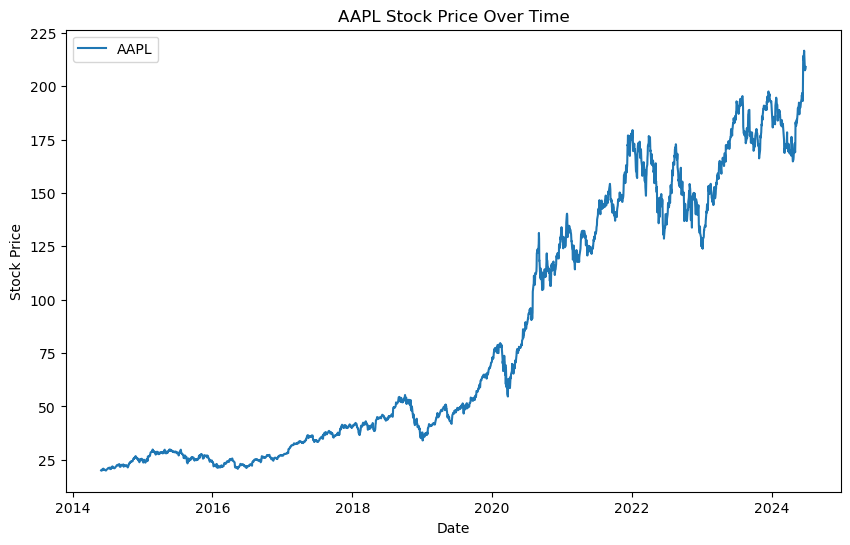

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(pivot_df['Date'], pivot_df['AAPL'], label='AAPL')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('AAPL Stock Price Over Time')
plt.legend()
plt.show()

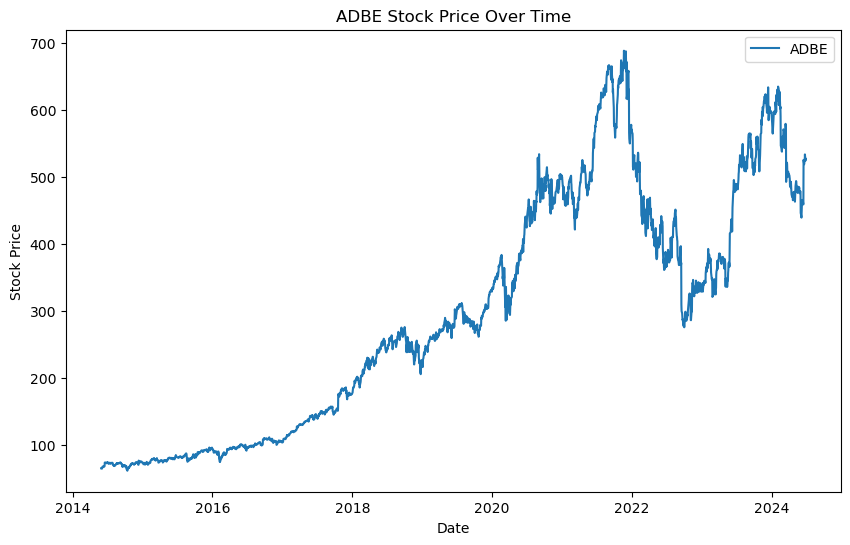

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(pivot_df['Date'], pivot_df['ADBE'], label='ADBE')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('ADBE Stock Price Over Time')
plt.legend()
plt.show()

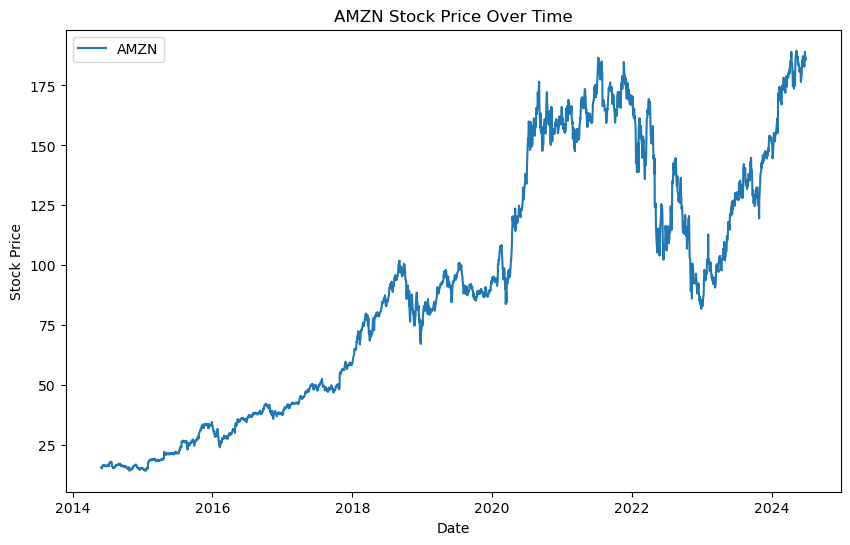

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(pivot_df['Date'], pivot_df['AMZN'], label='AMZN')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('AMZN Stock Price Over Time')
plt.legend()
plt.show()

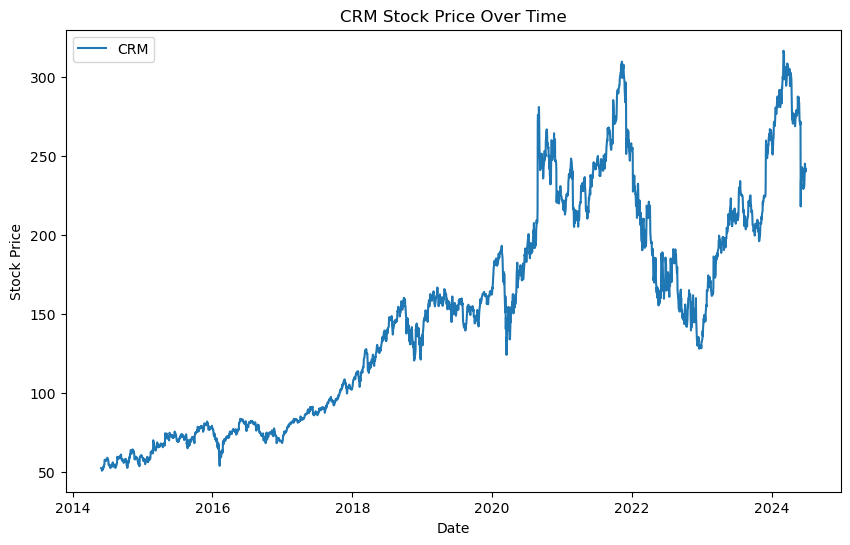

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(pivot_df['Date'], pivot_df['CRM'], label='CRM')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('CRM Stock Price Over Time')
plt.legend()
plt.show()

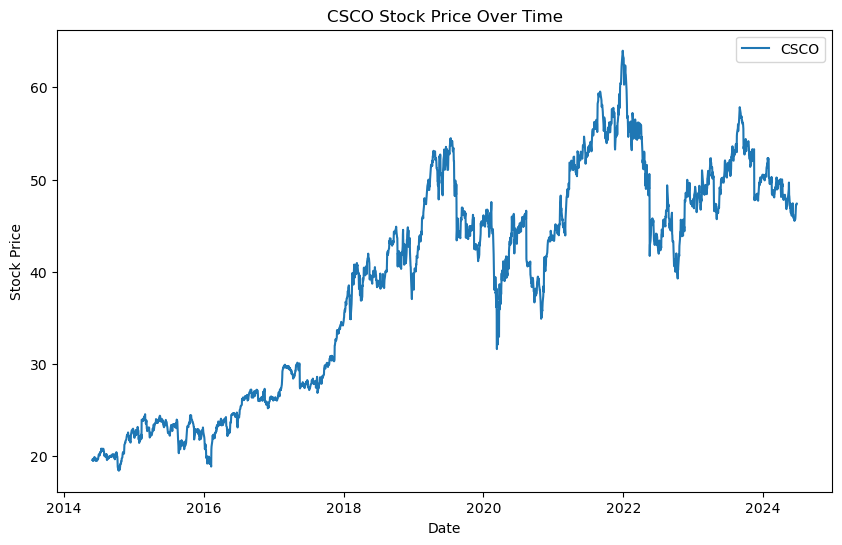

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(pivot_df['Date'], pivot_df['CSCO'], label='CSCO')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('CSCO Stock Price Over Time')
plt.legend()
plt.show()

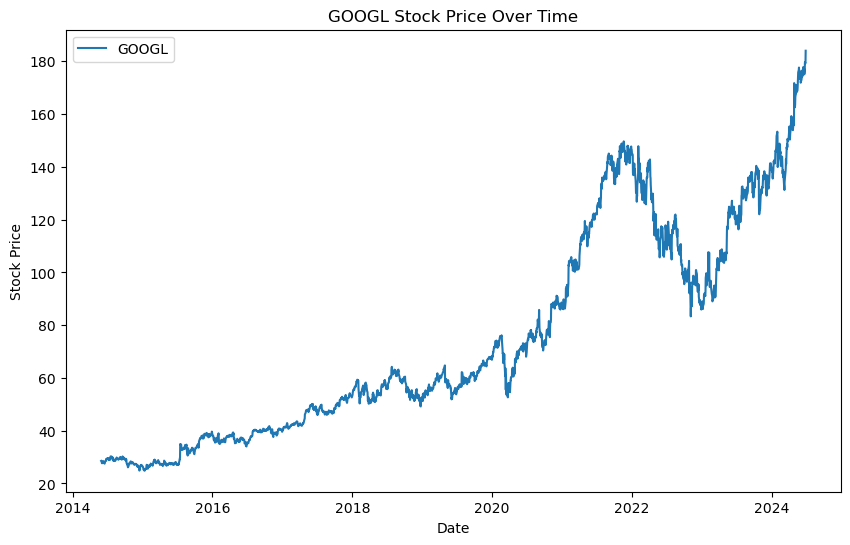

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(pivot_df['Date'], pivot_df['GOOGL'], label='GOOGL')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('GOOGL Stock Price Over Time')
plt.legend()
plt.show()

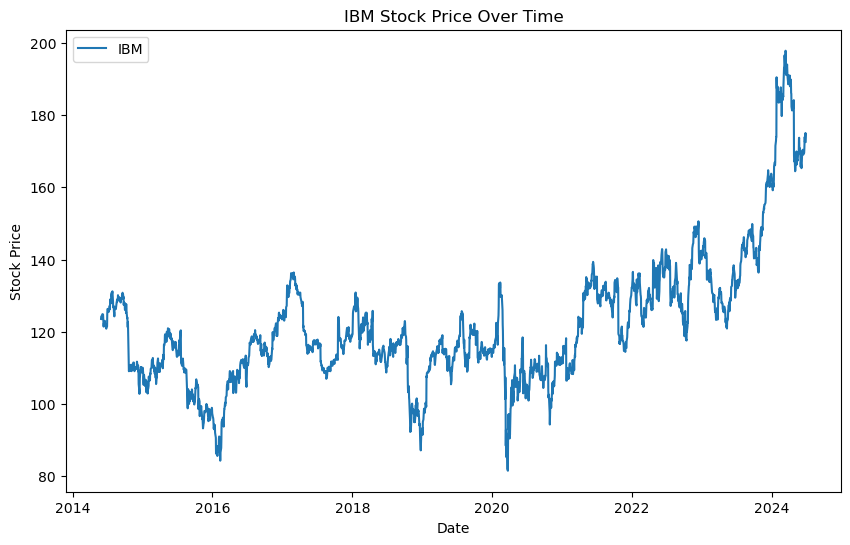

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(pivot_df['Date'], pivot_df['IBM'], label='IBM')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('IBM Stock Price Over Time')
plt.legend()
plt.show()

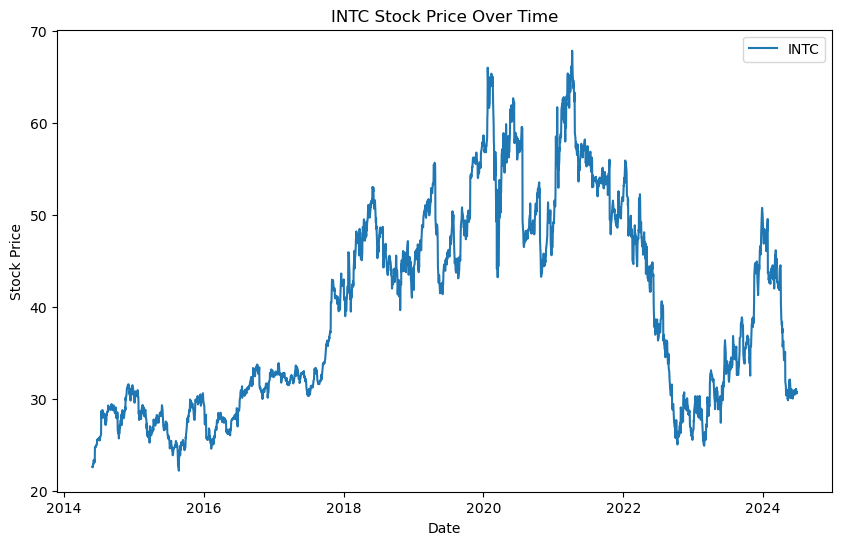

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(pivot_df['Date'], pivot_df['INTC'], label='INTC')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('INTC Stock Price Over Time')
plt.legend()
plt.show()

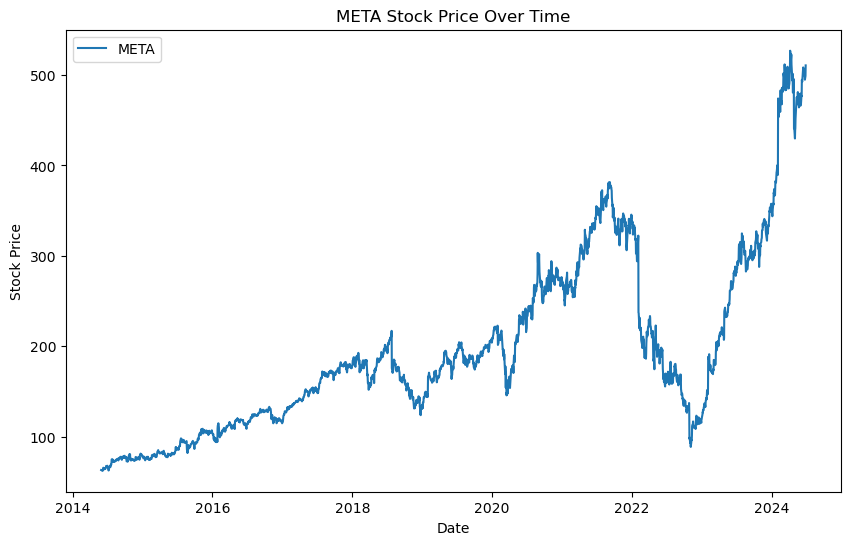

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(pivot_df['Date'], pivot_df['META'], label='META')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('META Stock Price Over Time')
plt.legend()
plt.show()

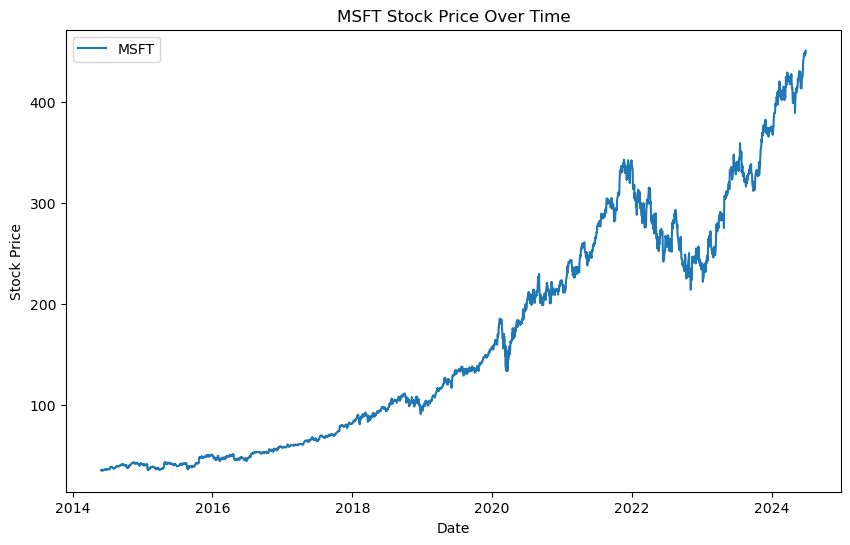

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(pivot_df['Date'], pivot_df['MSFT'], label='MSFT')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('MSFT Stock Price Over Time')
plt.legend()
plt.show()

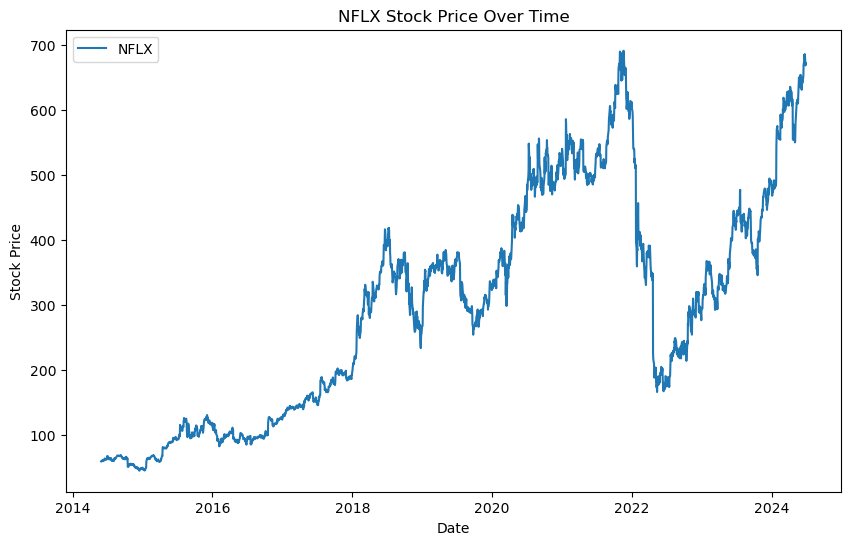

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(pivot_df['Date'], pivot_df['NFLX'], label='NFLX')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('NFLX Stock Price Over Time')
plt.legend()
plt.show()

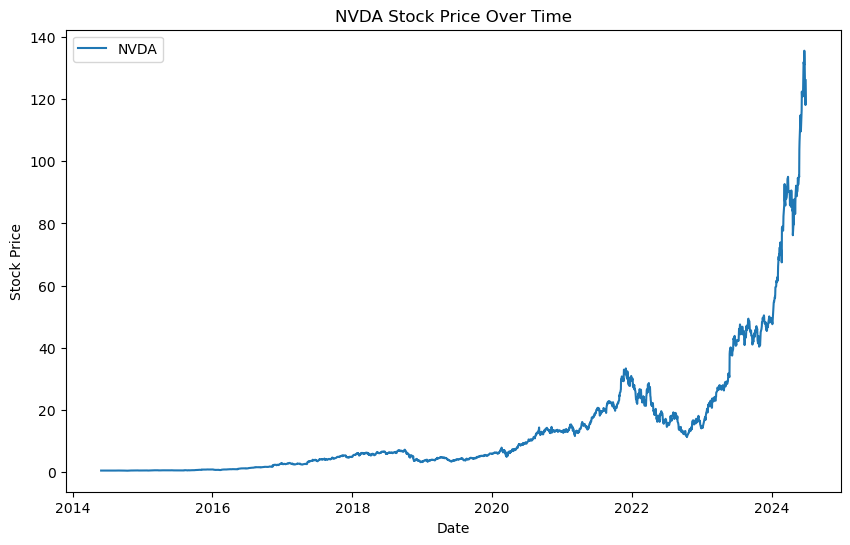

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(pivot_df['Date'], pivot_df['NVDA'], label='NVDA')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('NVDA Stock Price Over Time')
plt.legend()
plt.show()

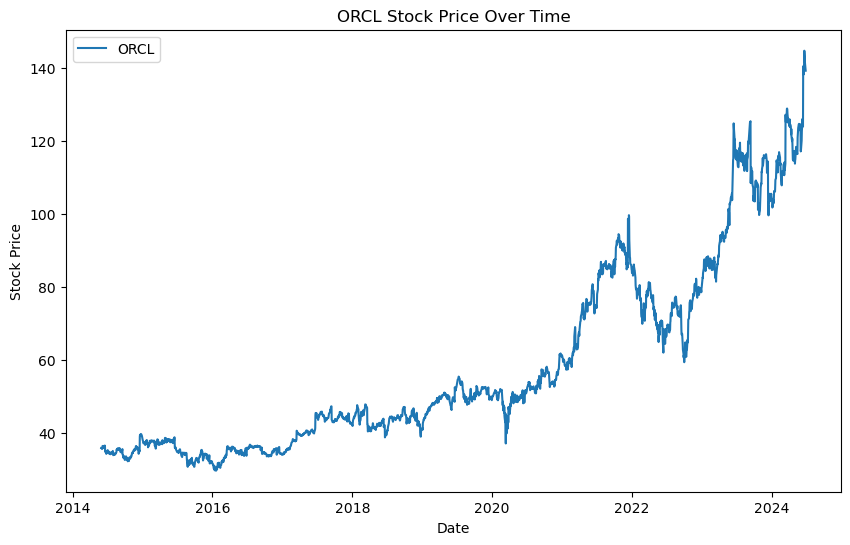

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(pivot_df['Date'], pivot_df['ORCL'], label='ORCL')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('ORCL Stock Price Over Time')
plt.legend()
plt.show()

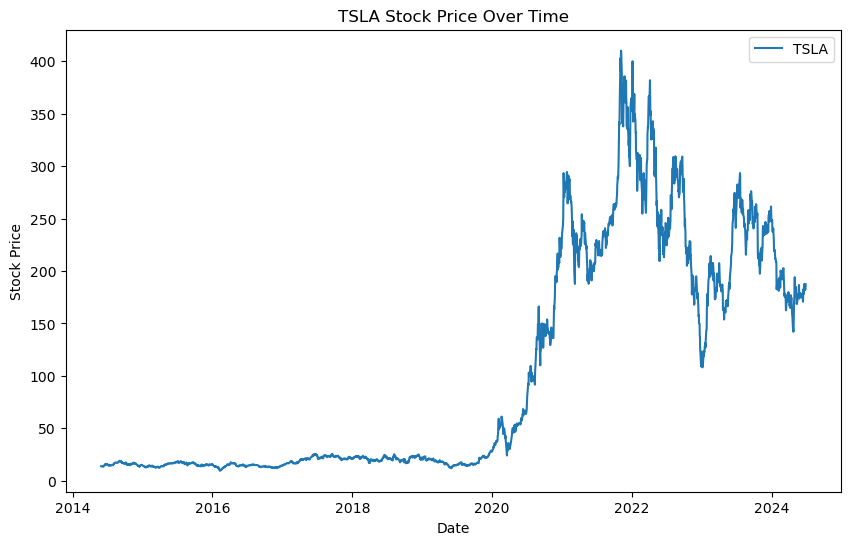

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(pivot_df['Date'], pivot_df['TSLA'], label='TSLA')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('TSLA Stock Price Over Time')
plt.legend()
plt.show()

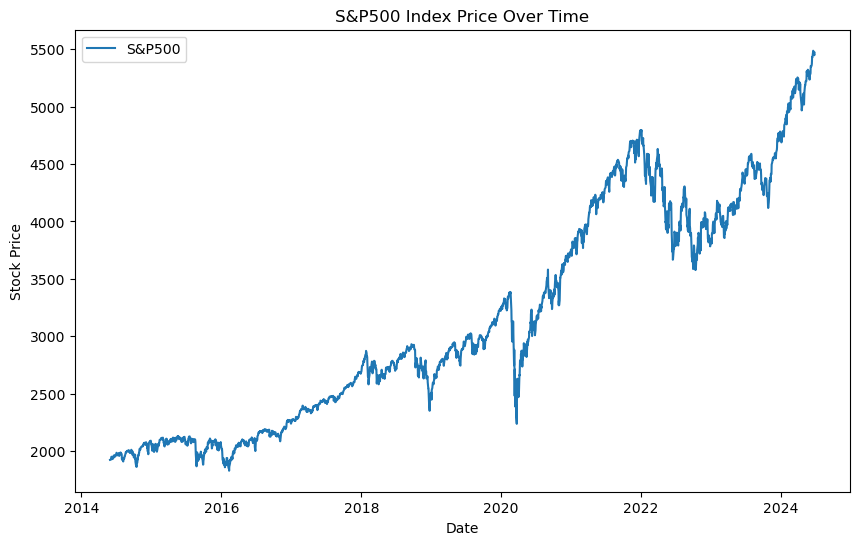

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(pivot_df['Date'], pivot_df['S&P500'], label='S&P500')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('S&P500 Index Price Over Time')
plt.legend()
plt.show()

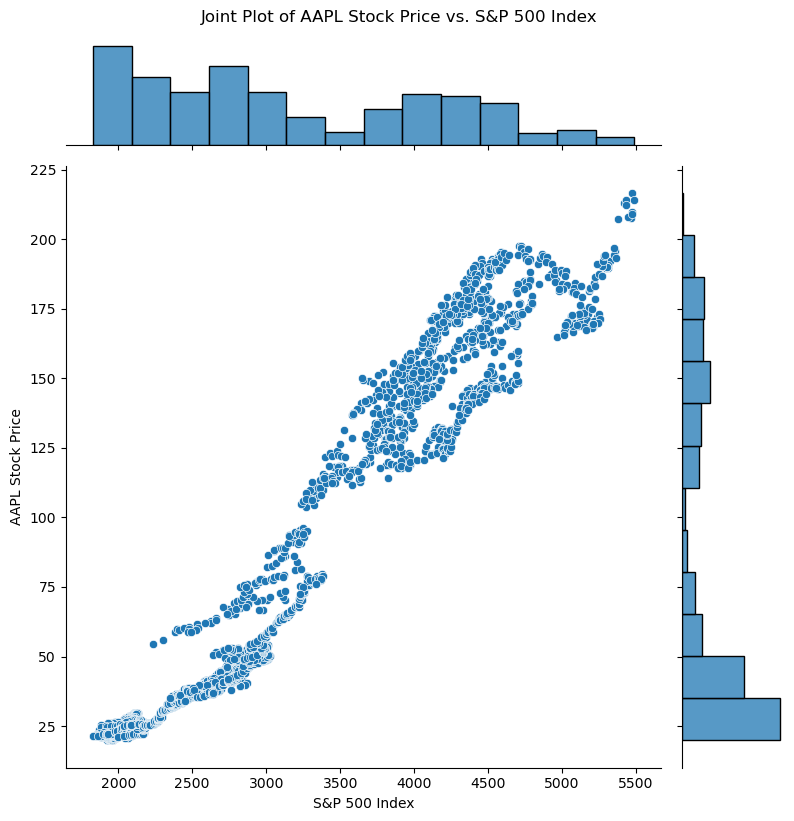

In [60]:
sns.jointplot(x='S&P500', y='AAPL', data=pivot_df, kind='scatter', height=8, ratio=5)
plt.xlabel('S&P 500 Index')
plt.ylabel('AAPL Stock Price')
plt.suptitle('Joint Plot of AAPL Stock Price vs. S&P 500 Index', y=1.02)
plt.show()

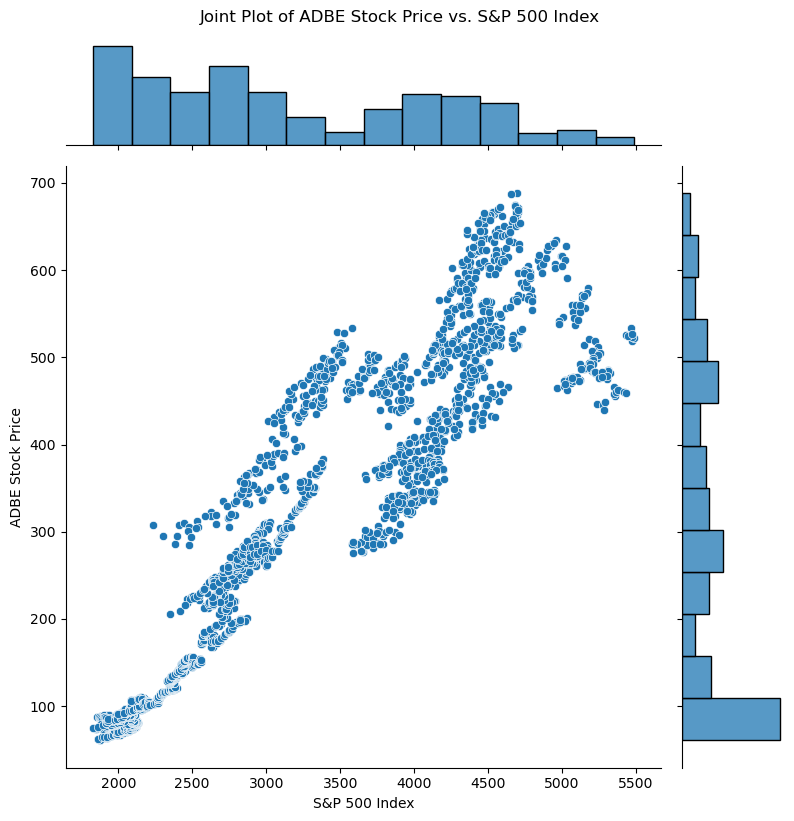

In [61]:
sns.jointplot(x='S&P500', y='ADBE', data=pivot_df, kind='scatter', height=8, ratio=5)
plt.xlabel('S&P 500 Index')
plt.ylabel('ADBE Stock Price')
plt.suptitle('Joint Plot of ADBE Stock Price vs. S&P 500 Index', y=1.02)
plt.show()

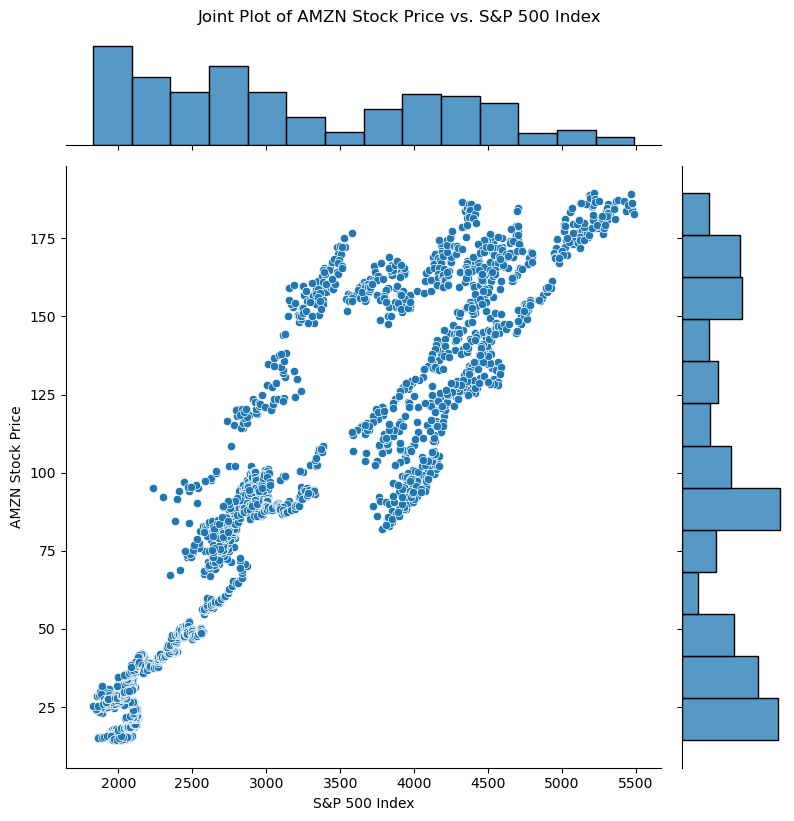

In [62]:
sns.jointplot(x='S&P500', y='AMZN', data=pivot_df, kind='scatter', height=8, ratio=5)
plt.xlabel('S&P 500 Index')
plt.ylabel('AMZN Stock Price')
plt.suptitle('Joint Plot of AMZN Stock Price vs. S&P 500 Index', y=1.02)
plt.show()

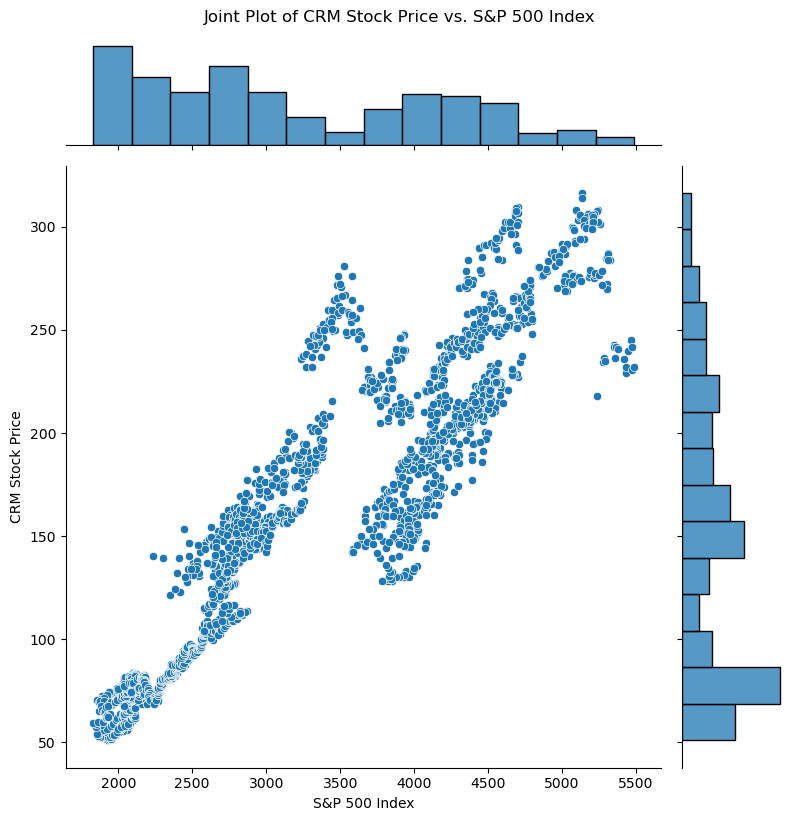

In [63]:
sns.jointplot(x='S&P500', y='CRM', data=pivot_df, kind='scatter', height=8, ratio=5)
plt.xlabel('S&P 500 Index')
plt.ylabel('CRM Stock Price')
plt.suptitle('Joint Plot of CRM Stock Price vs. S&P 500 Index', y=1.02)
plt.show()

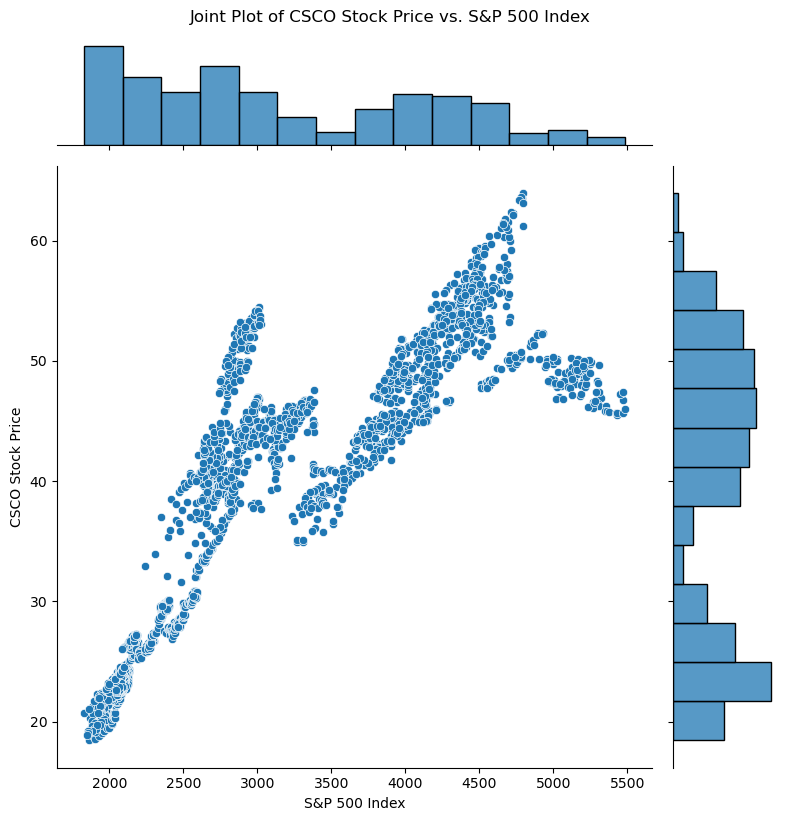

In [64]:
sns.jointplot(x='S&P500', y='CSCO', data=pivot_df, kind='scatter', height=8, ratio=5)
plt.xlabel('S&P 500 Index')
plt.ylabel('CSCO Stock Price')
plt.suptitle('Joint Plot of CSCO Stock Price vs. S&P 500 Index', y=1.02)
plt.show()

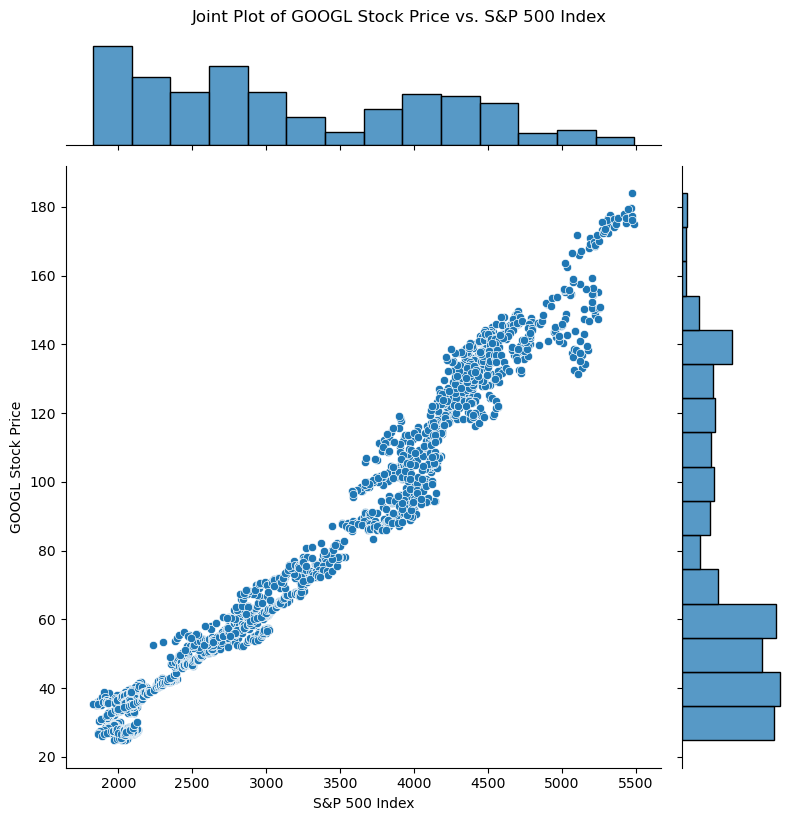

In [65]:
sns.jointplot(x='S&P500', y='GOOGL', data=pivot_df, kind='scatter', height=8, ratio=5)
plt.xlabel('S&P 500 Index')
plt.ylabel('GOOGL Stock Price')
plt.suptitle('Joint Plot of GOOGL Stock Price vs. S&P 500 Index', y=1.02)
plt.show()

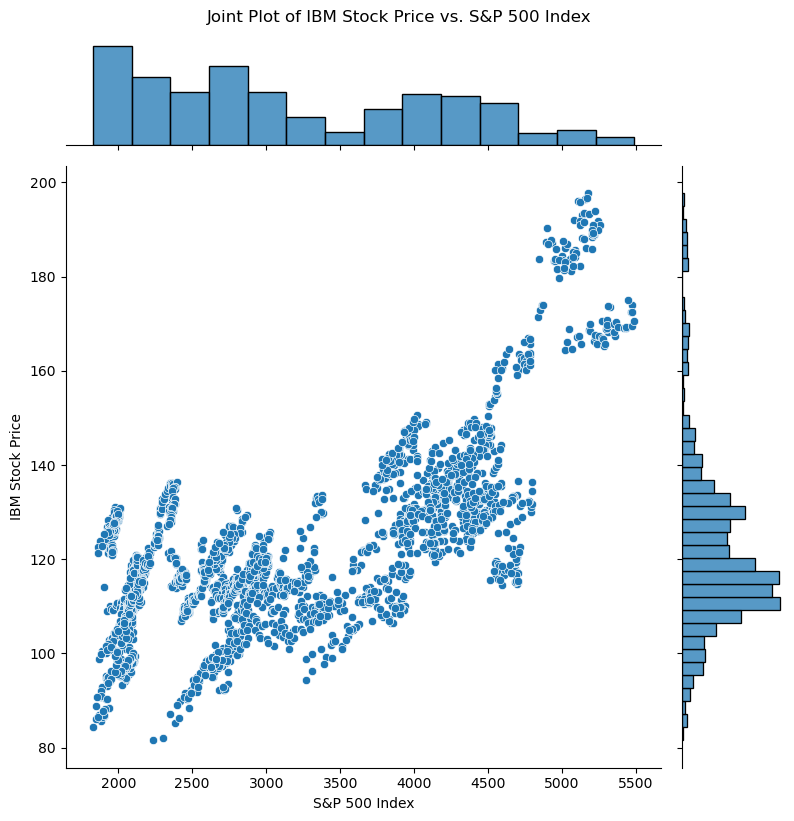

In [59]:
sns.jointplot(x='S&P500', y='IBM', data=pivot_df, kind='scatter', height=8, ratio=5)
plt.xlabel('S&P 500 Index')
plt.ylabel('IBM Stock Price')
plt.suptitle('Joint Plot of IBM Stock Price vs. S&P 500 Index', y=1.02)
plt.show()

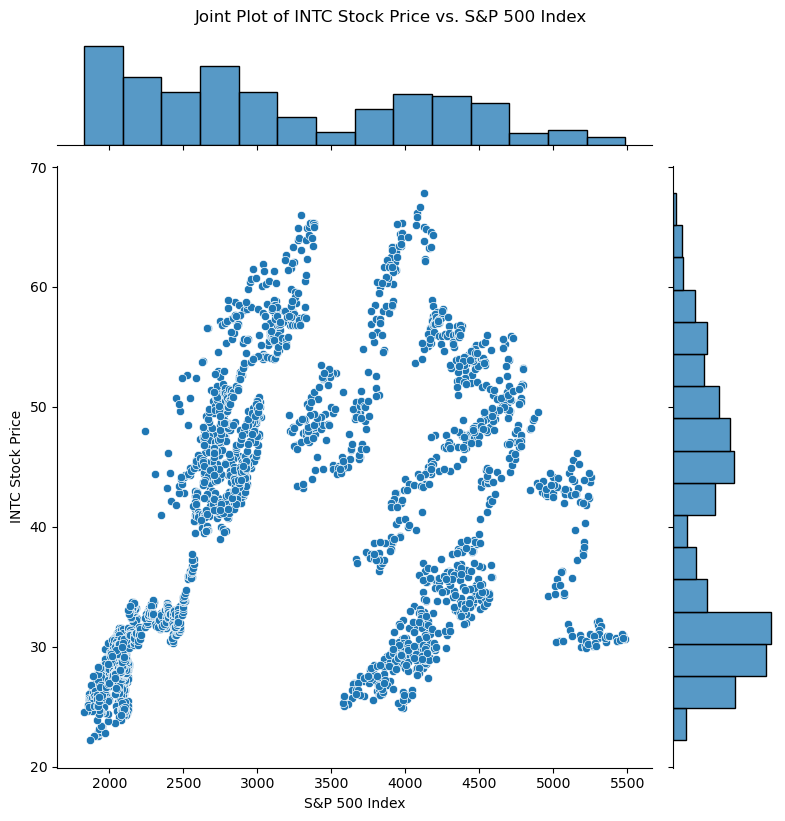

In [66]:
sns.jointplot(x='S&P500', y='INTC', data=pivot_df, kind='scatter', height=8, ratio=5)
plt.xlabel('S&P 500 Index')
plt.ylabel('INTC Stock Price')
plt.suptitle('Joint Plot of INTC Stock Price vs. S&P 500 Index', y=1.02)
plt.show()

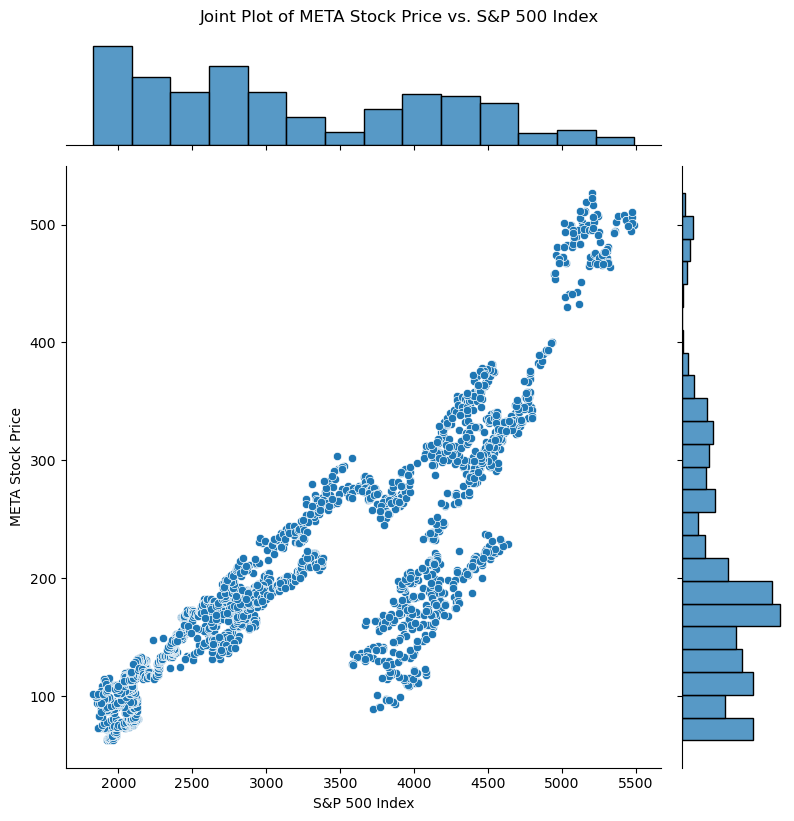

In [67]:
sns.jointplot(x='S&P500', y='META', data=pivot_df, kind='scatter', height=8, ratio=5)
plt.xlabel('S&P 500 Index')
plt.ylabel('META Stock Price')
plt.suptitle('Joint Plot of META Stock Price vs. S&P 500 Index', y=1.02)
plt.show()

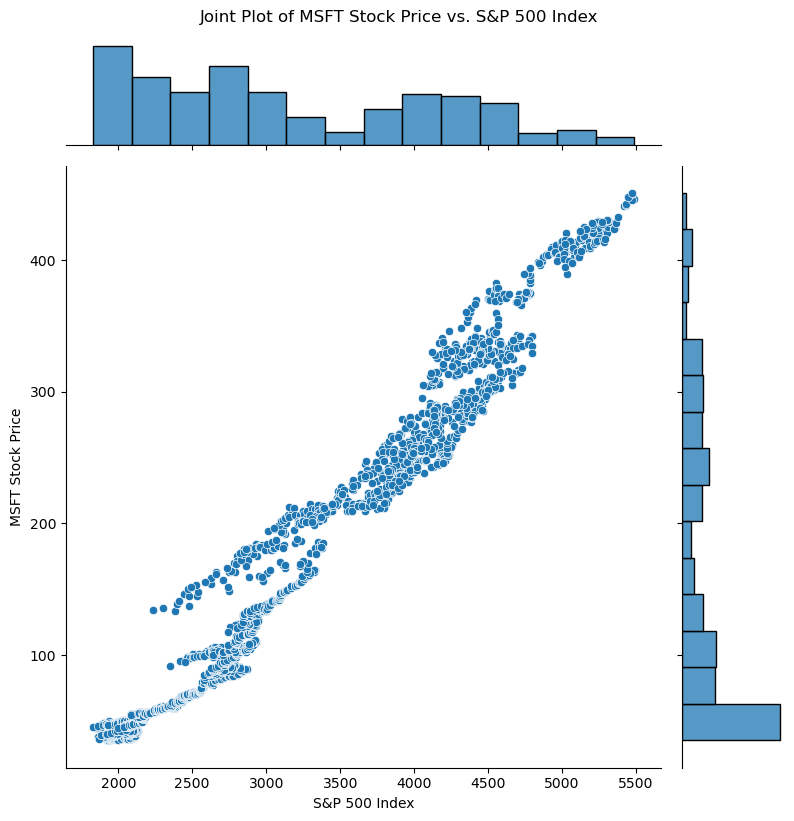

In [68]:
sns.jointplot(x='S&P500', y='MSFT', data=pivot_df, kind='scatter', height=8, ratio=5)
plt.xlabel('S&P 500 Index')
plt.ylabel('MSFT Stock Price')
plt.suptitle('Joint Plot of MSFT Stock Price vs. S&P 500 Index', y=1.02)
plt.show()

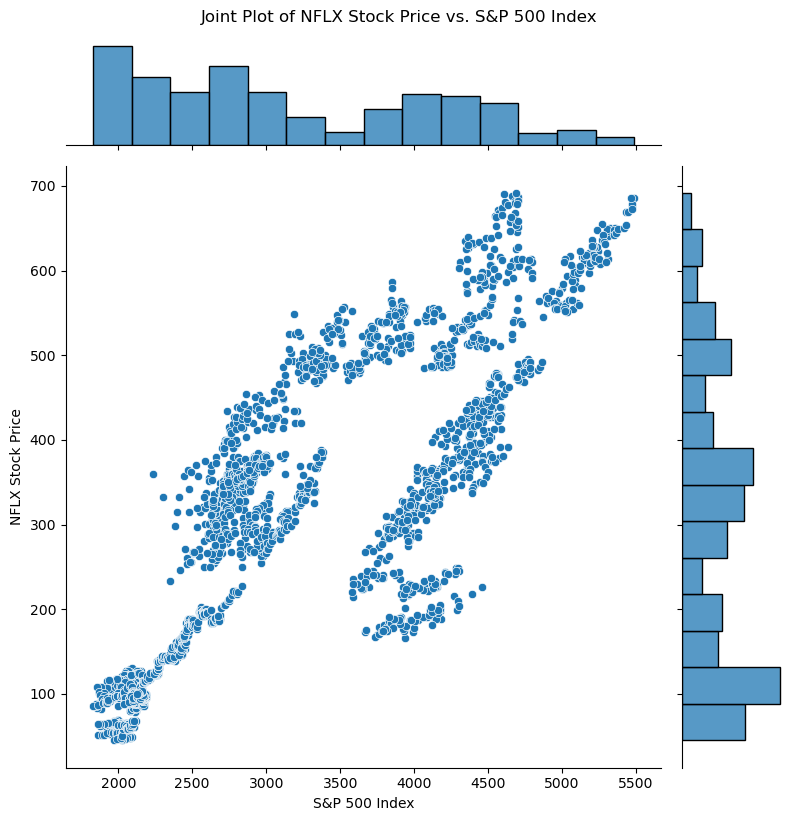

In [69]:
sns.jointplot(x='S&P500', y='NFLX', data=pivot_df, kind='scatter', height=8, ratio=5)
plt.xlabel('S&P 500 Index')
plt.ylabel('NFLX Stock Price')
plt.suptitle('Joint Plot of NFLX Stock Price vs. S&P 500 Index', y=1.02)
plt.show()

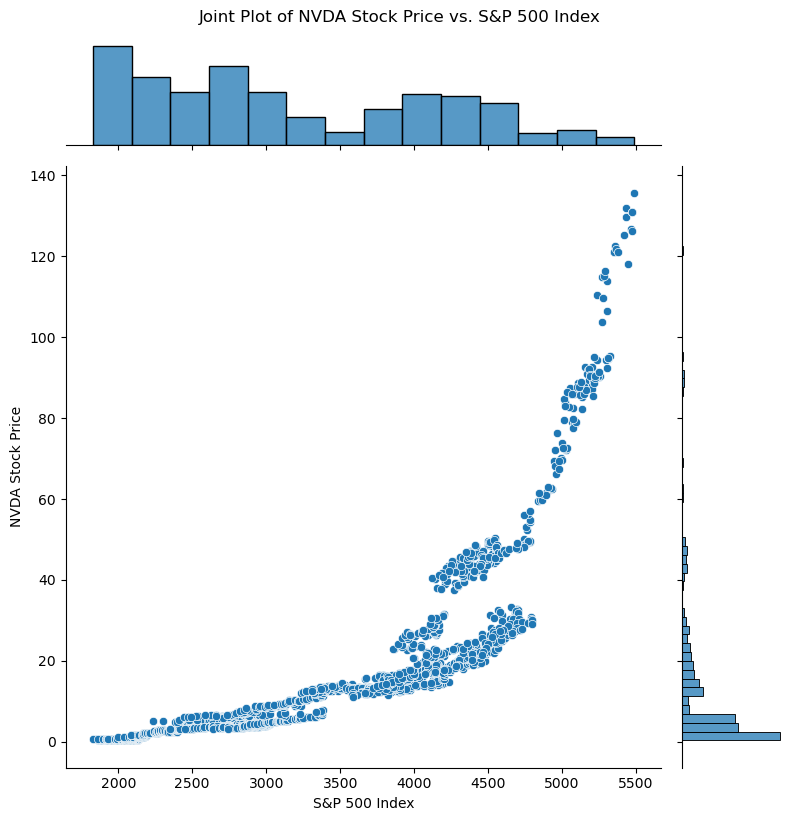

In [70]:
sns.jointplot(x='S&P500', y='NVDA', data=pivot_df, kind='scatter', height=8, ratio=5)
plt.xlabel('S&P 500 Index')
plt.ylabel('NVDA Stock Price')
plt.suptitle('Joint Plot of NVDA Stock Price vs. S&P 500 Index', y=1.02)
plt.show()

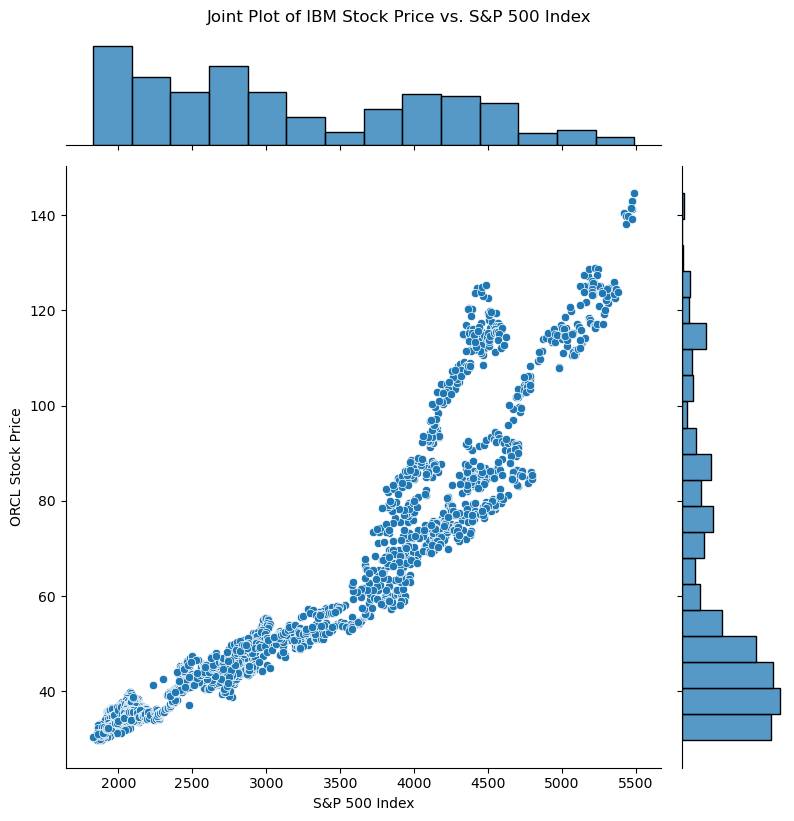

In [71]:
sns.jointplot(x='S&P500', y='ORCL', data=pivot_df, kind='scatter', height=8, ratio=5)
plt.xlabel('S&P 500 Index')
plt.ylabel('ORCL Stock Price')
plt.suptitle('Joint Plot of IBM Stock Price vs. S&P 500 Index', y=1.02)
plt.show()

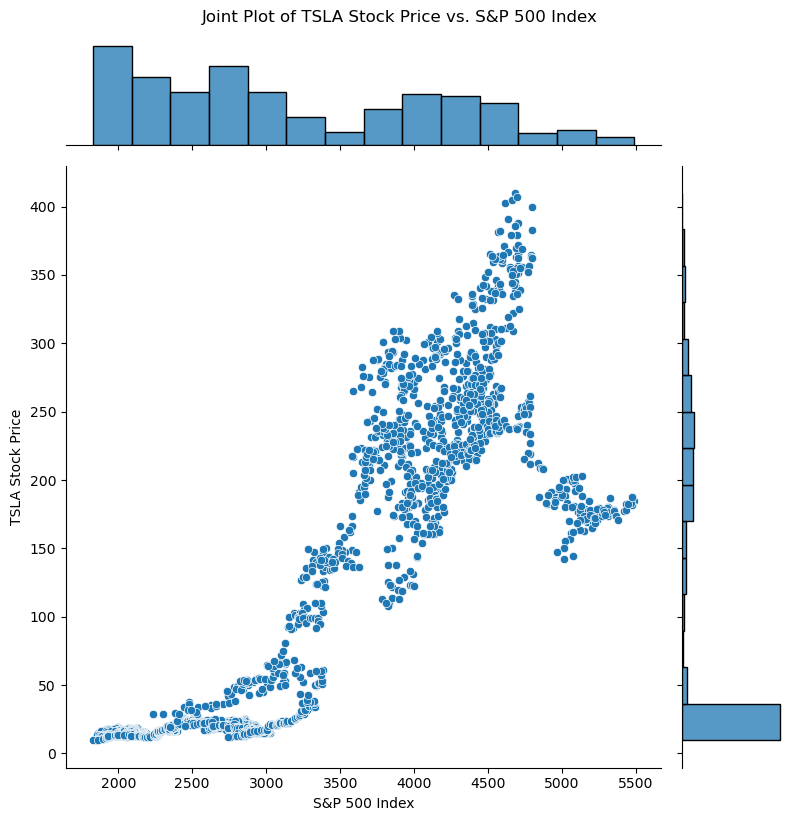

In [72]:
sns.jointplot(x='S&P500', y='TSLA', data=pivot_df, kind='scatter', height=8, ratio=5)
plt.xlabel('S&P 500 Index')
plt.ylabel('TSLA Stock Price')
plt.suptitle('Joint Plot of TSLA Stock Price vs. S&P 500 Index', y=1.02)
plt.show()

In [21]:
#Initial Multiple Linear Regression

#Making y my dependent variable
y = pivot_df['S&P500']
#Making X multiple independent variables
X = pivot_df[["AAPL","ADBE","AMZN","CRM","CSCO","GOOGL","IBM","INTC","META","MSFT","NFLX","NVDA","ORCL","TSLA"
]].assign(const=1)

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 S&P500   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 3.076e+04
Date:                Mon, 29 Jul 2024   Prob (F-statistic):               0.00
Time:                        14:01:10   Log-Likelihood:                -14512.
No. Observations:                2535   AIC:                         2.905e+04
Df Residuals:                    2520   BIC:                         2.914e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AAPL           6.6441      0.243     27.391      0.0

In [22]:
#Getting spread of the residuals around the regression line (Residual Standard Error)
results.resid.std(ddof=X.shape[1])

74.34189625086817

In [23]:
#Getting the Variance Inflation Factor (VIF)
X = pivot_df[["AAPL","ADBE","AMZN","CRM","CSCO","GOOGL","IBM","INTC","META","MSFT","NFLX","NVDA","ORCL","TSLA"
]]

vif_df = pd.DataFrame()
vif_df["feature"] = X.columns

vif_df["VIF"] = [variance_inflation_factor(X.values, i)
for i in range(len(X.columns))]

print(vif_df)

   feature         VIF
0     AAPL  275.014927
1     ADBE  178.531943
2     AMZN  207.444895
3      CRM  204.690745
4     CSCO  162.229964
5    GOOGL  241.905017
6      IBM   93.472756
7     INTC   87.697038
8     META  129.729838
9     MSFT  440.347017
10    NFLX   96.865251
11    NVDA   38.658954
12    ORCL  282.062071
13    TSLA   32.990251


In [24]:
#Dropping MSFT and getting the new VIF
X = pivot_df[["AAPL","ADBE","AMZN","CRM","CSCO","GOOGL","IBM","INTC","META","NFLX","NVDA","ORCL","TSLA"
]]

vif_df = pd.DataFrame()
vif_df["feature"] = X.columns

vif_df["VIF"] = [variance_inflation_factor(X.values, i)
for i in range(len(X.columns))]

print(vif_df)

   feature         VIF
0     AAPL  169.818419
1     ADBE  158.434161
2     AMZN  207.209509
3      CRM  187.860833
4     CSCO  161.097098
5    GOOGL  221.495151
6      IBM   87.864786
7     INTC   87.286821
8     META  124.158720
9     NFLX   93.179273
10    NVDA   26.483471
11    ORCL  281.864458
12    TSLA   30.871504


In [25]:
#Dropping ORCL and getting the new VIF
X = pivot_df[["AAPL","ADBE","AMZN","CRM","CSCO","GOOGL","IBM","INTC","META","NFLX","NVDA","TSLA"
]]

vif_df = pd.DataFrame()
vif_df["feature"] = X.columns

vif_df["VIF"] = [variance_inflation_factor(X.values, i)
for i in range(len(X.columns))]

print(vif_df)

   feature         VIF
0     AAPL  120.827382
1     ADBE  150.449093
2     AMZN  130.641462
3      CRM  187.644583
4     CSCO  120.093514
5    GOOGL  220.863676
6      IBM   61.837250
7     INTC   80.130795
8     META  114.787146
9     NFLX   88.741374
10    NVDA   24.277505
11    TSLA   30.636007


In [26]:
#Dropping GOOGL and getting the new VIF
X = pivot_df[["AAPL","ADBE","AMZN","CRM","CSCO","IBM","INTC","META","NFLX","NVDA","TSLA"
]]

vif_df = pd.DataFrame()
vif_df["feature"] = X.columns

vif_df["VIF"] = [variance_inflation_factor(X.values, i)
for i in range(len(X.columns))]

print(vif_df)

   feature         VIF
0     AAPL  120.084953
1     ADBE  149.138968
2     AMZN  127.375919
3      CRM  186.498640
4     CSCO   83.675667
5      IBM   61.084050
6     INTC   80.103751
7     META  103.784498
8     NFLX   83.399147
9     NVDA   19.975952
10    TSLA   20.076971


In [27]:
#Dropping CRM and getting the new VIF
X = pivot_df[["AAPL","ADBE","AMZN","CSCO","IBM","INTC","META","NFLX","NVDA","TSLA"
]]

vif_df = pd.DataFrame()
vif_df["feature"] = X.columns

vif_df["VIF"] = [variance_inflation_factor(X.values, i)
for i in range(len(X.columns))]

print(vif_df)

  feature         VIF
0    AAPL  118.275325
1    ADBE  138.470662
2    AMZN  119.859444
3    CSCO   83.629975
4     IBM   56.028285
5    INTC   80.076734
6    META   99.922888
7    NFLX   73.828235
8    NVDA   19.699419
9    TSLA   19.992333


In [28]:
#Dropping ADBE and getting the new VIF
X = pivot_df[["AAPL","AMZN","CSCO","IBM","INTC","META","NFLX","NVDA","TSLA"
]]

vif_df = pd.DataFrame()
vif_df["feature"] = X.columns

vif_df["VIF"] = [variance_inflation_factor(X.values, i)
for i in range(len(X.columns))]

print(vif_df)

  feature         VIF
0    AAPL   82.405884
1    AMZN  119.476941
2    CSCO   82.633110
3     IBM   45.322743
4    INTC   77.781571
5    META   78.698032
6    NFLX   67.699722
7    NVDA   16.907927
8    TSLA   19.910276


In [29]:
#Dropping AMZN and getting the new VIF
X = pivot_df[["AAPL","CSCO","IBM","INTC","META","NFLX","NVDA","TSLA"
]]

vif_df = pd.DataFrame()
vif_df["feature"] = X.columns

vif_df["VIF"] = [variance_inflation_factor(X.values, i)
for i in range(len(X.columns))]

print(vif_df)

  feature        VIF
0    AAPL  69.673570
1    CSCO  82.630466
2     IBM  39.263982
3    INTC  67.926677
4    META  72.875717
5    NFLX  50.853690
6    NVDA  16.763684
7    TSLA  19.313624


In [30]:
#Dropping CSCO and getting the new VIF
X = pivot_df[["AAPL","IBM","INTC","META","NFLX","NVDA","TSLA"
]]

vif_df = pd.DataFrame()
vif_df["feature"] = X.columns

vif_df["VIF"] = [variance_inflation_factor(X.values, i)
for i in range(len(X.columns))]

print(vif_df)

  feature        VIF
0    AAPL  55.459387
1     IBM  30.013699
2    INTC  59.995600
3    META  70.574553
4    NFLX  44.132433
5    NVDA  16.169286
6    TSLA  18.675503


In [31]:
#Dropping META and getting the new VIF
X = pivot_df[["AAPL","IBM","INTC","NFLX","NVDA","TSLA"
]]

vif_df = pd.DataFrame()
vif_df["feature"] = X.columns

vif_df["VIF"] = [variance_inflation_factor(X.values, i)
for i in range(len(X.columns))]

print(vif_df)

  feature        VIF
0    AAPL  52.382336
1     IBM  27.855576
2    INTC  53.630076
3    NFLX  33.024953
4    NVDA   8.737446
5    TSLA  17.846932


In [32]:
#Dropping INTC and getting the new VIF
X = pivot_df[["AAPL","IBM","NFLX","NVDA","TSLA"
]]

vif_df = pd.DataFrame()
vif_df["feature"] = X.columns

vif_df["VIF"] = [variance_inflation_factor(X.values, i)
for i in range(len(X.columns))]

print(vif_df)

  feature        VIF
0    AAPL  52.141763
1     IBM   7.723816
2    NFLX   8.639095
3    NVDA   4.549839
4    TSLA  17.823315


In [33]:
#Dropping AAPL and getting the new VIF
X = pivot_df[["IBM","NFLX","NVDA","TSLA"
]]

vif_df = pd.DataFrame()
vif_df["feature"] = X.columns

vif_df["VIF"] = [variance_inflation_factor(X.values, i)
for i in range(len(X.columns))]

print(vif_df)

  feature       VIF
0     IBM  4.744422
1    NFLX  7.777467
2    NVDA  2.613113
3    TSLA  3.597808


In [34]:
#Start of Backward Stepwise Elimination based on p-values no greater than 0.05 after dropping of vairiables due to VIF

#Making y my dependent variable
y = pivot_df['S&P500']
#Making X multiple independent variables
X = pivot_df[["IBM","NFLX","NVDA","TSLA"
]].assign(const=1)

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 S&P500   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                 1.649e+04
Date:                Mon, 29 Jul 2024   Prob (F-statistic):               0.00
Time:                        14:39:16   Log-Likelihood:                -16855.
No. Observations:                2535   AIC:                         3.372e+04
Df Residuals:                    2530   BIC:                         3.375e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
IBM           11.3320      0.363     31.255      0.0

In [35]:
#Getting spread of the residuals around the regression line (Residual Standard Error)
results.resid.std(ddof=X.shape[1])

186.9759511282064

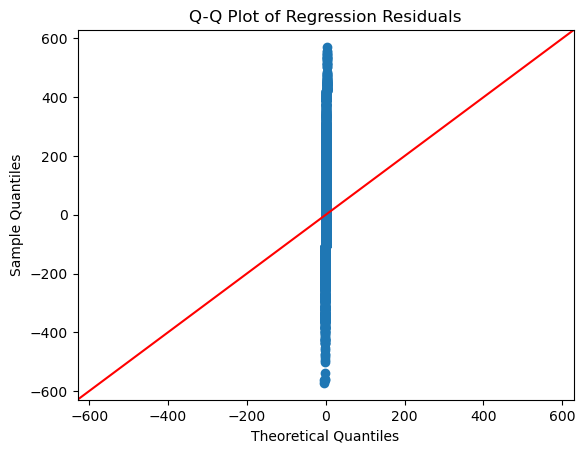

In [37]:
# Extract the residuals
residuals = results.resid

# Generate the Q-Q plot
sm.qqplot(residuals, line='45')
plt.title('Q-Q Plot of Regression Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

In [73]:
print(residuals.describe())

count    2.535000e+03
mean    -4.500474e-12
std      1.868283e+02
min     -5.723364e+02
25%     -1.161206e+02
50%     -1.563715e+01
75%      1.068711e+02
max      5.712546e+02
dtype: float64


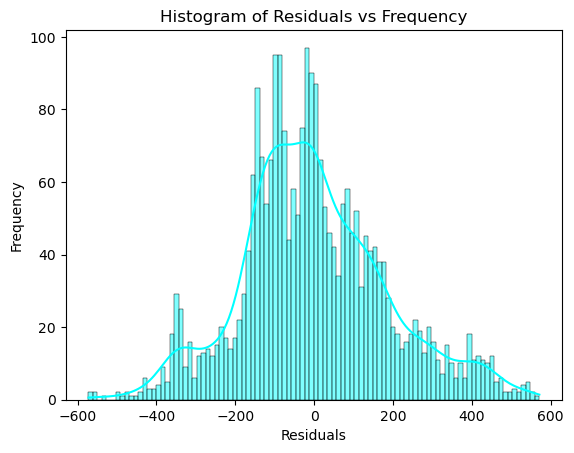

In [38]:
#Histogram of the frequency of residuals
sns.histplot(residuals, bins=100, kde=True, color='cyan')
plt.title('Histogram of Residuals vs Frequency')
plt.xlabel('Residuals')
plt.ylabel('Frequency');

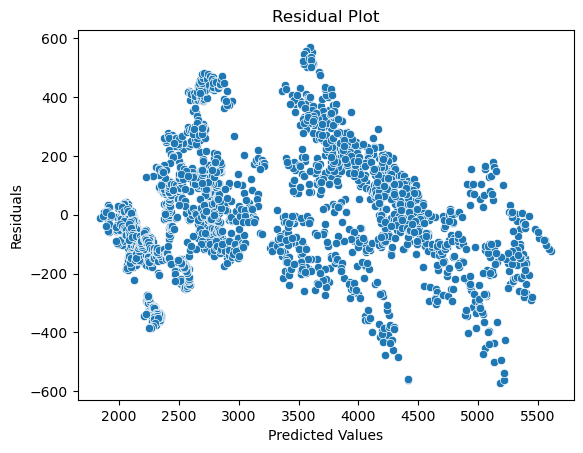

In [39]:
#Verifying my model meets the assumption Homoscedasticity
predictions = results.predict()

sns.scatterplot(x=predictions, y=residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

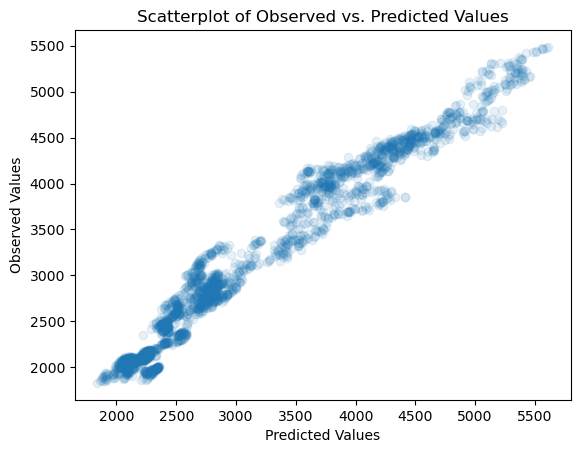

In [40]:
# Create a scatterplot of observed vs. predicted values
plt.scatter(predictions, y, alpha = 0.1)
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.title('Scatterplot of Observed vs. Predicted Values')
plt.show()

In [41]:
# Create new dataset with only the variables in reduced multiple linear regression to do a heatmap
mdf = pivot_df[["IBM","NFLX","NVDA","TSLA", "S&P500"
]]

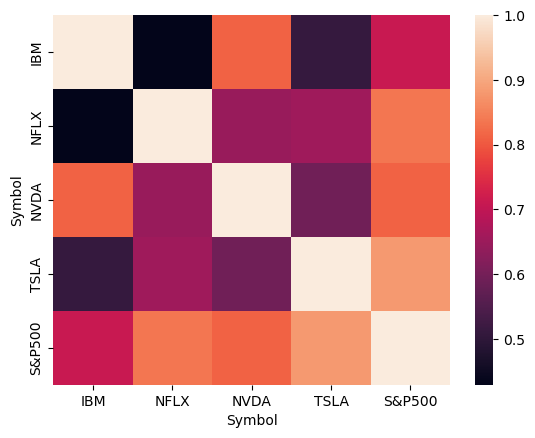

In [42]:
#Running the heatmap
sns.heatmap(mdf.corr());